In [1]:
import mlflow
from mlflow import sklearn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from mlflow.models import infer_signature
import dagshub
import os

### Connect to mlflow

In [ ]:
dagshub.init(repo_owner='guavacoderepo', repo_name='churn_prediction_app', mlflow=True) # type: ignore
tracking_url = os.getenv("TRACKING_URI", "http://127.0.0.1:5000")
experiment_name = os.getenv("EXPERIMENT_NAME", "Default")

mlflow.set_tracking_uri(tracking_url)
exp = mlflow.get_experiment_by_name(experiment_name) # type: ignore

if exp is None:
    mlflow.create_experiment(
        name= experiment_name,
        tags={
            "mlflow.note.content": "Customer churn prediction pipeline",
            "team": "AI engineering team",
            "project": "churn_prediction_end_to_end"
        },
        # artifact_location="src/data/churn_pred_models"
    )
    exp = mlflow.get_experiment_by_name(experiment_name)
    print("✅ Created new experiment:", exp.experiment_id) # type: ignore
if exp is None:
    raise RuntimeError("❌ Failed to create or fetch MLflow experiment.")

Accessing as guavacoderepo

Initialized MLflow to track repo "guavacoderepo/churn_prediction_app"

Repository guavacoderepo/churn_prediction_app initialized!

churn_prediction_exp
✅ Created new experiment: 4


### Load dataset for training model


In [3]:
X_train = np.load("../src/data/X_train_scaled.npy")
X_test = np.load("../src/data/X_test_scaled.npy")
y_train = np.load("../src/data/y_train.npy", allow_pickle=True)
y_test = np.load("../src/data/y_test.npy", allow_pickle=True)

### Mlflow helper function

In [4]:
run_name = "churn_pred"

def mlflow_logging(params, metrics, model_name, sk_model):
    with mlflow.start_run(run_name=run_name, experiment_id=exp.experiment_id): # type: ignore
        try:
            # Log to mlflow
            for key, val in params.items():
                mlflow.log_param(key=key, value=val)

            for key, val in metrics.items():
                mlflow.log_metric(key=key, value=val)

             # Tags
            tags = {"mlflow.note.content": f"{model_name} training outcome",
                "model_name": model_name}

            for key, val in tags.items():
                mlflow.set_tag(key=key, value=val)

            mlflow.sklearn.log_model( # type: ignore
                sk_model=sk_model,
                artifact_path=f"{model_name}_artifact",
                input_example=X_test[:5],
                registered_model_name=f"{model_name}_models", 
                signature=infer_signature(X_train[:10], sk_model.predict(X_test[:5]))
            )
            
            print(f"✅ Done logging {model_name}")
        except Exception as e:
            raise Exception(F"Model logging error: {e}") from e

In [5]:
rs = 42 # Random state

### Let's build a base model using decision tree

In [6]:
model_name = "decision_tree"

# Train out model
dtc_m1_params = {"max_depth":None, "criterion":'gini', "random_state":rs}
dtc_m1_model = DecisionTreeClassifier(**dtc_m1_params)

dtc_m1_model = dtc_m1_model.fit(X=X_train, y=y_train)
y_pred = dtc_m1_model.predict(X=X_test)

# Metrics
dtc_m1_metrics = {
    "accuracy": accuracy_score(y_test, y_pred), # type: ignore
    "f1": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred)
}

print(dtc_m1_metrics)
# Logging to mlflow
mlflow_logging(dtc_m1_params, dtc_m1_metrics, model_name, dtc_m1_model)

{'accuracy': 0.8794772507260407, 'f1': 0.8880898876404495, 'recall': 0.946360153256705, 'precision': 0.8365791701947503}


Successfully registered model 'decision_tree_models'.
2025/09/27 18:04:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: decision_tree_models, version 1
Created version '1' of model 'decision_tree_models'.


✅ Done logging decision_tree
🏃 View run churn_pred at: https://dagshub.com/guavacoderepo/churn_prediction_app.mlflow/#/experiments/4/runs/31366aa81b09409480c6c1efe4bbff54
🧪 View experiment at: https://dagshub.com/guavacoderepo/churn_prediction_app.mlflow/#/experiments/4


              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1022
           1       0.84      0.95      0.89      1044

    accuracy                           0.88      2066
   macro avg       0.89      0.88      0.88      2066
weighted avg       0.89      0.88      0.88      2066

ROC-AUC: 0.8787573760412684


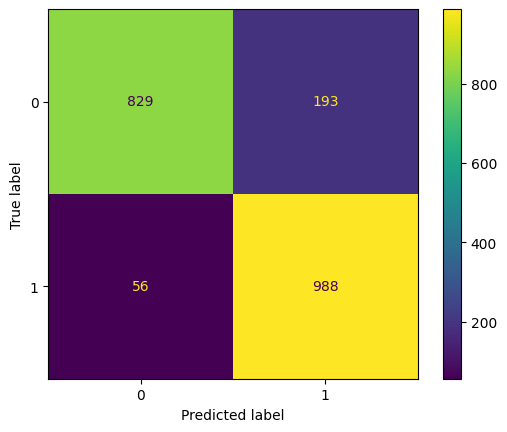

In [7]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_m1_model.classes_)
disp.plot();

# Now let's fine tune hyperparametr and retrain

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

n_trials = 100

def objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "criterion": trial.suggest_categorical("criterion", ["entropy", "gini"]),
        "random_state":rs
    }

    model = DecisionTreeClassifier(**params)
    model = model.fit(X=X_train, y=y_train)
    y_pred = model.predict(X=X_test)

    acc = accuracy_score(y_test, y_pred)

    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials, n_jobs=1) # type: ignore

/home/evan-linux/Desktop/Machine Learning/Churn_prediction/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
dtc_m2_model = DecisionTreeClassifier(**study.best_params)
dtc_m2_model = dtc_m2_model.fit(X=X_train, y=y_train)
y_pred = dtc_m2_model.predict(X=X_test)

# Metrics
dtc_m2_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred)
}

print(dtc_m2_metrics)
# Logging to mlflow
mlflow_logging(study.best_params, dtc_m2_metrics, model_name, dtc_m2_model)

{'accuracy': 0.8693126815101646, 'f1': 0.8790322580645161, 'recall': 0.9396551724137931, 'precision': 0.8257575757575758}


Successfully registered model 'random_forest_models'.
2025/09/27 18:05:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_models, version 1
Created version '1' of model 'random_forest_models'.


✅ Done logging random_forest
🏃 View run churn_pred at: https://dagshub.com/guavacoderepo/churn_prediction_app.mlflow/#/experiments/4/runs/703f1018a1c24e019b6913b044f1a163
🧪 View experiment at: https://dagshub.com/guavacoderepo/churn_prediction_app.mlflow/#/experiments/4


              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1022
           1       0.83      0.94      0.88      1044

    accuracy                           0.87      2066
   macro avg       0.88      0.87      0.87      2066
weighted avg       0.88      0.87      0.87      2066

ROC-AUC: 0.8685555705513193


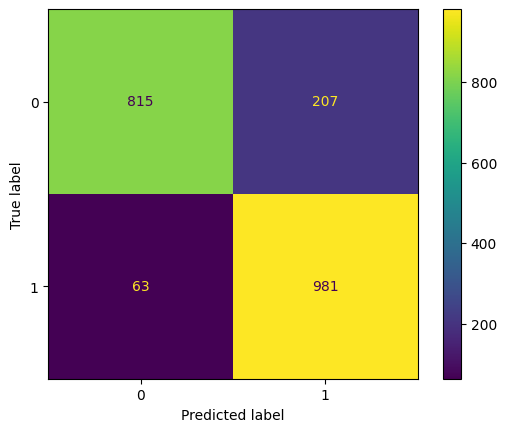

In [14]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_m2_model.classes_)
disp.plot();

## Lets try random forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

model_name = "random_forest"

rfc_m1_params = {
    "n_estimators":50, "criterion":"gini", "max_depth":10, "class_weight":'balanced_subsample', "random_state":rs
}

y_train_rev = y_train.ravel()
y_test_rev = y_test.ravel()

rfc_m1_model = RandomForestClassifier(**rfc_m1_params)
rfc_m1_model = rfc_m1_model.fit(X_train, y_train_rev)
y_pred = rfc_m1_model.predict(X_test)

# Metrics
rfc_m1_metrics = {
    "accuracy": accuracy_score(y_test_rev, y_pred),
    "f1": f1_score(y_test_rev, y_pred),
    "recall": recall_score(y_test_rev, y_pred),
    "precision": precision_score(y_test_rev, y_pred)
}

print(rfc_m1_metrics)
# Logging to mlflow
mlflow_logging(rfc_m1_metrics, rfc_m1_metrics, model_name, rfc_m1_model)

{'accuracy': 0.8407550822846079, 'f1': 0.8533214444939813, 'recall': 0.9166666666666666, 'precision': 0.7981651376146789}


Registered model 'random_forest_models' already exists. Creating a new version of this model...
2025/09/27 18:05:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_models, version 2
Created version '2' of model 'random_forest_models'.


✅ Done logging random_forest
🏃 View run churn_pred at: https://dagshub.com/guavacoderepo/churn_prediction_app.mlflow/#/experiments/4/runs/e3804380eaac4731b28d4ce60524b0fb
🧪 View experiment at: https://dagshub.com/guavacoderepo/churn_prediction_app.mlflow/#/experiments/4


              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1022
           1       0.80      0.92      0.85      1044

    accuracy                           0.84      2066
   macro avg       0.85      0.84      0.84      2066
weighted avg       0.85      0.84      0.84      2066

ROC-AUC: 0.8399380300065231


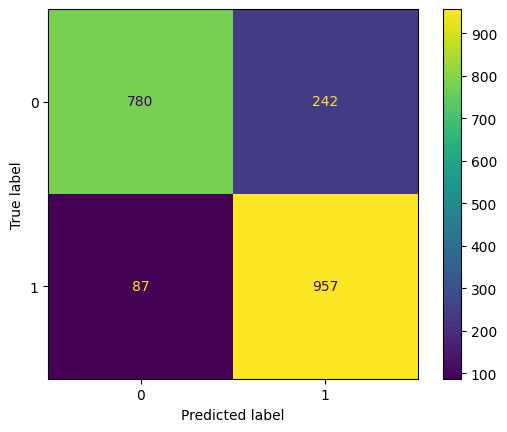

In [16]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_m1_model.classes_)
disp.plot();

## Let's optimize the hyperparameters 

In [24]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "criterion": trial.suggest_categorical("criterion", ["entropy", "gini", "log_loss"]),
        "random_state":rs
    }

    model = RandomForestClassifier(**params, n_jobs=-1)
    model = model.fit(X_train, y_train_rev)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test_rev, y_pred)

    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials, n_jobs=1)

In [26]:
rfc_m2_model = RandomForestClassifier(**study.best_params)
rfc_m2_model = rfc_m2_model.fit(X=X_train, y=y_train_rev)
y_pred = rfc_m2_model.predict(X=X_test)

# Metrics
rfc_m2_metrics = {
    "accuracy": accuracy_score(y_test_rev, y_pred),
    "f1": f1_score(y_test_rev, y_pred),
    "recall": recall_score(y_test_rev, y_pred),
    "precision": precision_score(y_test_rev, y_pred)
}

print(rfc_m2_metrics)
# Logging to mlflow
mlflow_logging(study.best_params, rfc_m2_metrics, model_name, rfc_m2_model)

{'accuracy': 0.8925459825750242, 'f1': 0.900626678603402, 'recall': 0.9636015325670498, 'precision': 0.8453781512605042}


Registered model 'random_forest_models' already exists. Creating a new version of this model...
2025/09/27 18:16:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_models, version 4
Created version '4' of model 'random_forest_models'.


✅ Done logging random_forest
🏃 View run churn_pred at: https://dagshub.com/guavacoderepo/churn_prediction_app.mlflow/#/experiments/4/runs/12e5a1c7a0104ef9a9010345cee01f5f
🧪 View experiment at: https://dagshub.com/guavacoderepo/churn_prediction_app.mlflow/#/experiments/4


              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1022
           1       0.85      0.96      0.90      1044

    accuracy                           0.89      2066
   macro avg       0.90      0.89      0.89      2066
weighted avg       0.90      0.89      0.89      2066

ROC-AUC: 0.8917811968119006


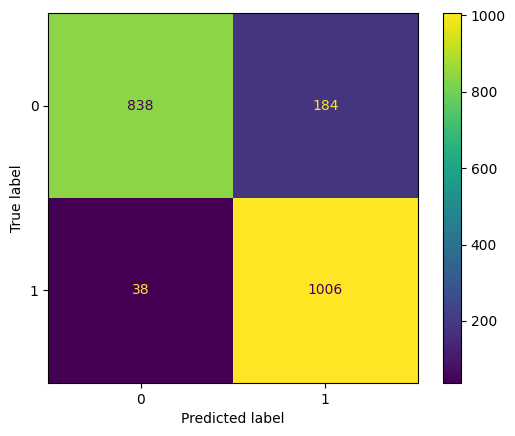

In [27]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_m2_model.classes_)
disp.plot();